In [3]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


In [4]:
import yfinance as yfin
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import smtplib
import time
import datetime as dt
import sklearn
from selenium import webdriver  # untuk ambil data dari web
from sklearn.linear_model import LinearRegression
from pandas_datareader import data as wb
import warnings

warnings.simplefilter("ignore") # abaikan pesan warning
yfin.pdr_override() # override library yfinance ke pandas datareader

# set the size of the plot
rcParams['figure.figsize'] = 20, 10

# untuk normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))

# start = '2022-9-27'
# end = '2020-6-30'
start = dt.datetime.today() - dt.timedelta(days=365) # mulai dari 1 tahun yang lalu
end = dt.datetime.today() # sampai hari ini

# tulis nama saham yang ingin diambil datanya, TLKM dalam yfinance adalah TLKM.JK
tickers = ['TLKM.JK']
prices = [] # raw data dari yahoo finance
price_data = [] # sudah di assign nama sahamnya dan hanya mengambil Adj Close saja
for ticker in tickers:
    prices = wb.get_data_yahoo(ticker, start=start, end=end) # ambil data dari yahoo finance
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Adj Close']]) # di assign nama sahamnya dan hanya mengambil Adj Close saja

# print ke csv
pd.DataFrame(prices).to_csv('tlkm.csv')
print(price_data)

[*********************100%***********************]  1 of 1 completed
[             ticker    Adj Close
Date                            
2022-06-28  TLKM.JK  3867.247559
2022-06-29  TLKM.JK  3876.843506
2022-06-30  TLKM.JK  3838.458984
2022-07-01  TLKM.JK  3857.651367
2022-07-04  TLKM.JK  3828.862793
...             ...          ...
2023-06-21  TLKM.JK  3980.000000
2023-06-22  TLKM.JK  3940.000000
2023-06-23  TLKM.JK  3950.000000
2023-06-26  TLKM.JK  3990.000000
2023-06-27  TLKM.JK  4000.000000

[247 rows x 2 columns]]


In [5]:
# concat data untuk dimasukkan ke model dataframe
df = pd.concat(price_data)
df.dtypes, df.shape

(ticker        object
 Adj Close    float64
 dtype: object,
 (247, 2))

In [6]:
# buat index baru untuk dataframe dengan nama Date (asumsi bahwa data yang diambil adalah data harian yang harusnya memiliki index tanggal)
df = df.reset_index() # reset semua index
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d') # selanjutnya buat index baru dengan nama Date
df.index = df['Date']

print(df)

                 Date   ticker    Adj Close
Date                                       
2022-06-28 2022-06-28  TLKM.JK  3867.247559
2022-06-29 2022-06-29  TLKM.JK  3876.843506
2022-06-30 2022-06-30  TLKM.JK  3838.458984
2022-07-01 2022-07-01  TLKM.JK  3857.651367
2022-07-04 2022-07-04  TLKM.JK  3828.862793
...               ...      ...          ...
2023-06-21 2023-06-21  TLKM.JK  3980.000000
2023-06-22 2023-06-22  TLKM.JK  3940.000000
2023-06-23 2023-06-23  TLKM.JK  3950.000000
2023-06-26 2023-06-26  TLKM.JK  3990.000000
2023-06-27 2023-06-27  TLKM.JK  4000.000000

[247 rows x 3 columns]


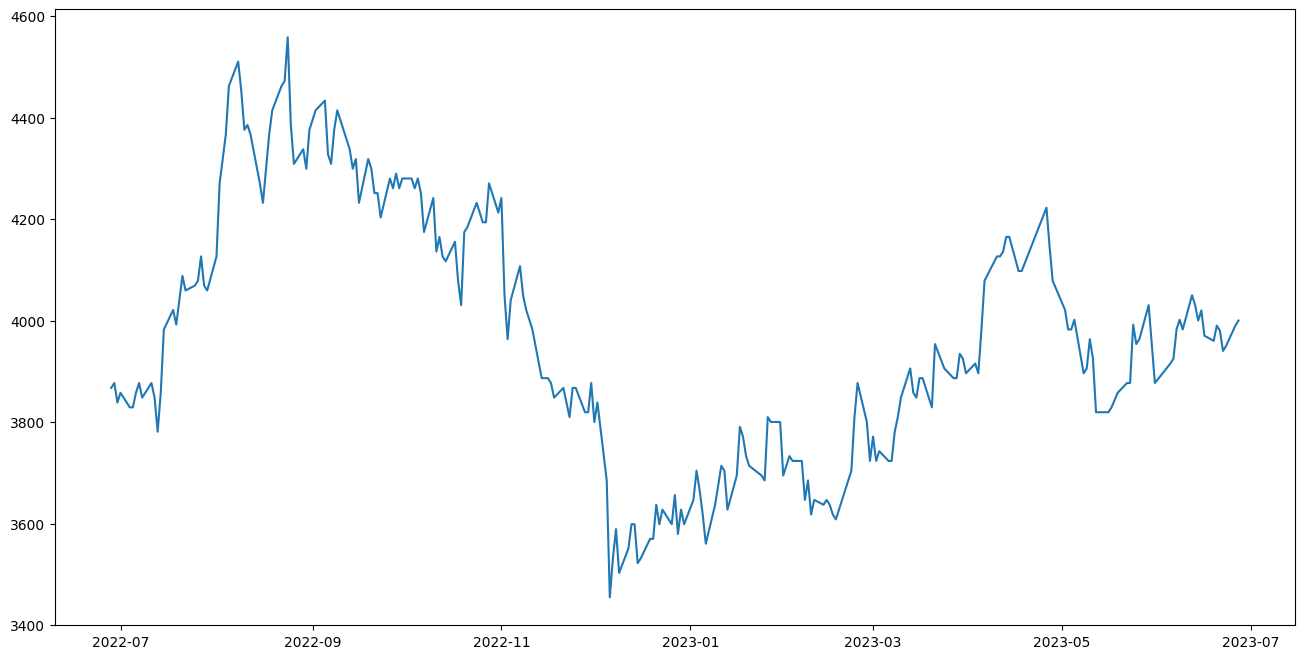

In [7]:
# plot model yang sudah dibuat
plt.figure(figsize=(16, 8))
plt.plot(df['Adj Close'], label='Close Price history')

In [8]:
# persiapan pembuatan model training
data = df.sort_index(ascending=True, axis=0) # diurutkan berdasarkan index yang berupa tanggal, dari tanggal terlama ke terbaru
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Adj Close']) # buat dataframe baru dengan 2 kolom yaitu Date dan Adj Close
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj Close'][i] = data['Adj Close'][i]

# buat model training dan validasi
train = new_data[:200]  # train data 200 data pertama
valid = new_data[-50:]  # validasi dari 50 data terakhir

new_data.shape, train.shape, valid.shape


((247, 2), (200, 2), (50, 2))

In [9]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

# buat prediksi
preds = []
for i in range(0, 50):
    a = train['Adj Close'][len(train)-50+i:].sum() + sum(preds) # 50 data terakhir ditambah dengan hasil prediksi sebelumnya
    b = a/50 # di bagi 50
    preds.append(b) # hasil prediksi dimasukkan ke array preds

# hitung rmse (root mean square error), semakin kecil rmse maka semakin baik modelnya (0 adalah nilai terbaik)
rms = np.sqrt(np.mean(np.power((np.array(valid['Adj Close'])-preds), 2)))
print(preds)
print(rms)


[3794.5086474609375, 3794.2054073242184, 3794.0880262128903, 3793.968297479336, 3795.95732651486, 3797.602293357657, 3798.8963118810602, 3800.4081346030566, 3801.950193779493, 3805.0584749988325, 3807.4612314128717, 3811.255504869254, 3814.5498923103896, 3818.102091328472, 3821.5334104987915, 3825.225279880642, 3829.3748343063803, 3833.7993036487583, 3837.160724292046, 3840.2055256919493, 3842.9273754636006, 3843.592509886935, 3842.927489967486, 3843.784550509023, 3846.194138003579, 3847.6923029902136, 3850.1800455343923, 3852.3336952732047, 3854.9142656630443, 3857.5464474606806, 3859.079734808331, 3860.067916418561, 3860.3081712313065, 3859.4016930543703, 3859.4366995717073, 3859.664330047517, 3859.128822703155, 3858.5826052119055, 3859.1770014567683, 3857.2882856265287, 3856.3214097374967, 3855.719043986934, 3855.1046309213602, 3853.5183153366625, 3852.092192385583, 3851.2133184598574, 3849.933019399367, 3849.0109620139174, 3846.3431587932578, 3841.702766109748]
189.43124931703252


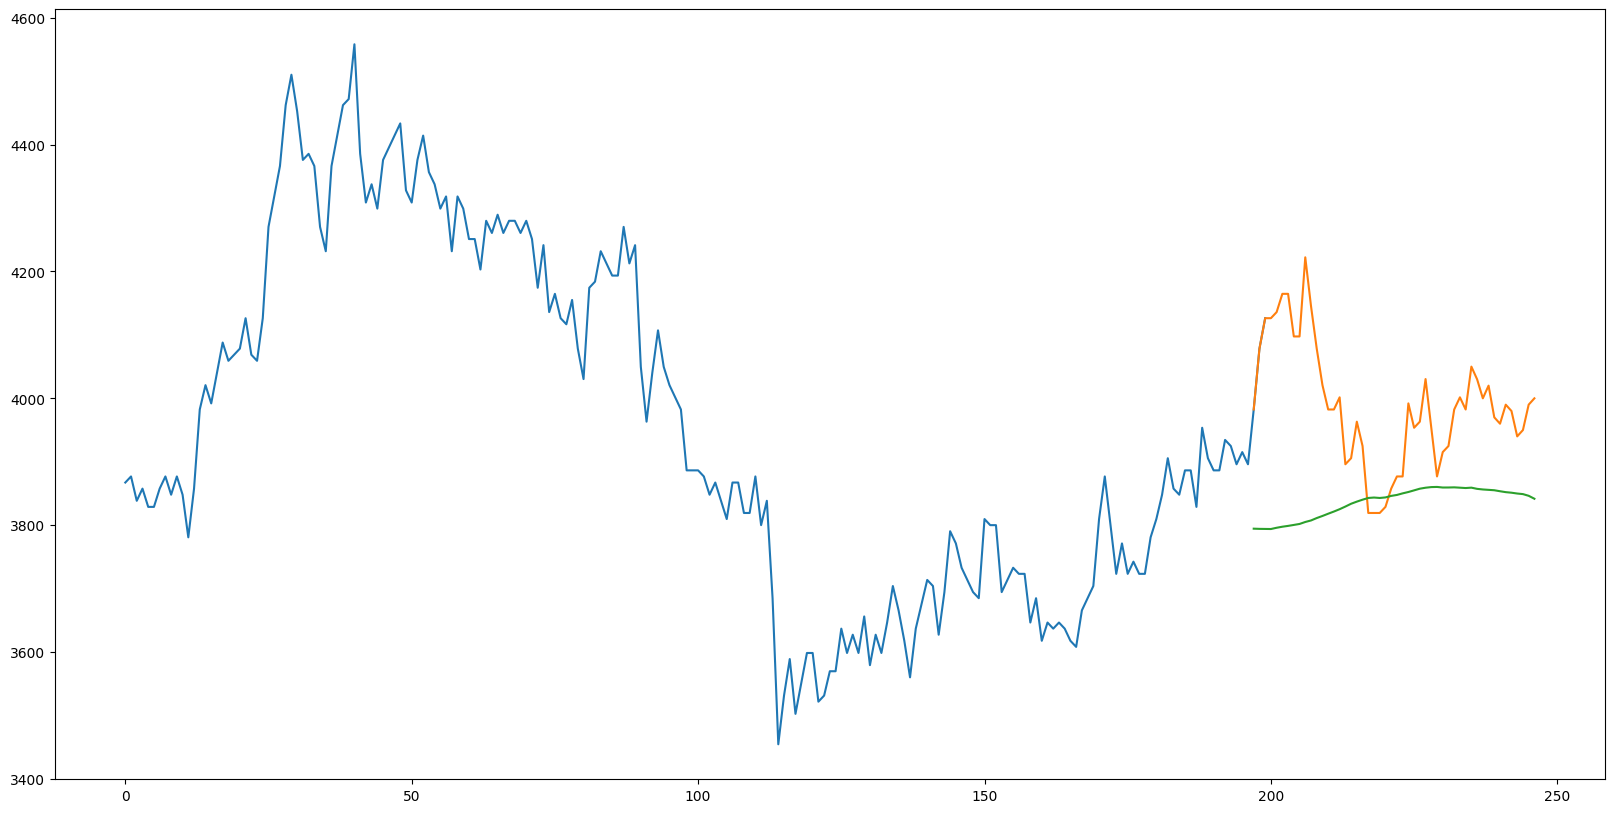

In [10]:
# plot hasil prediksi
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])

In [11]:
# Dalam statistik, regresi linier adalah pendekatan linier untuk memodelkan hubungan antara respons skalar (atau variabel dependen)
# dan satu atau lebih variabel penjelas (atau variabel independen). Kasus satu variabel penjelas disebut regresi linier sederhana.

# Regresi linier; algoritma ML yang paling dasar yang dapat diterapkan, dalam kasus ini akan ditambahkan rangkaian fitur yang relevan untuk proses prediksi.
# Contoh, berdasarkan hipotesis mengenai saham, diasumsikan bahwa hari pertama dan terakhir dalam satu pekan berpotensi mempengaruhi harga penutupan saham
# jauh lebih banyak daripada hari-hari lainnya.
# Jadi fitur yang akan ditambahkan adalah identifikasi apakah hari tertentu adalah Senin/Jumat atau Selasa/Rabu/Kamis. Intinya dipisah menjadi 2 kategori (senin-jumat dan selasa-rabu-kamis)

# set index berdasarkan tanggal
from sklearn.linear_model import LinearRegression
data = df.sort_index(ascending=True, axis=0)
df['day_of_week'] = df['Date'].dt.dayofweek

# fitur baru yang mengidentifikasi apakah tanggal itu Senin/Jumat atau Selasa/Rabu/Kamis
df['mon_fri'] = 0
for i in range(0, len(new_data)):
    if (df['day_of_week'][i] == 0 or df['day_of_week'][i] == 4):
        df['mon_fri'][i] = 1
    else:
        df['mon_fri'][i] = 0

# split data menjadi training dan validasi sama seperti sebelumnya
train = df[:200]
valid = df[-50:]

train.shape, valid.shape, train.dtypes

((200, 5),
 (50, 5),
 Date           datetime64[ns]
 ticker                 object
 Adj Close             float64
 day_of_week             int64
 mon_fri                 int64
 dtype: object)

In [12]:
# salin data ke variabel baru untuk mempersiapkan model training dengan regresi linier
x_train = train[['Adj Close', 'mon_fri']].copy()
y_train = train[['Adj Close', 'mon_fri']].copy()
x_valid = valid[['Adj Close', 'mon_fri']].copy()
y_valid = valid[['Adj Close', 'mon_fri']].copy()

# mulai implementasi model regresi linier
model = LinearRegression()
model.fit(x_train, y_train)

# buat prediksi terhadap model dan hitung rmse
preds = model.predict(x_valid)
rms = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)), 2)))
print(rms)


1.3013507047204118e-16


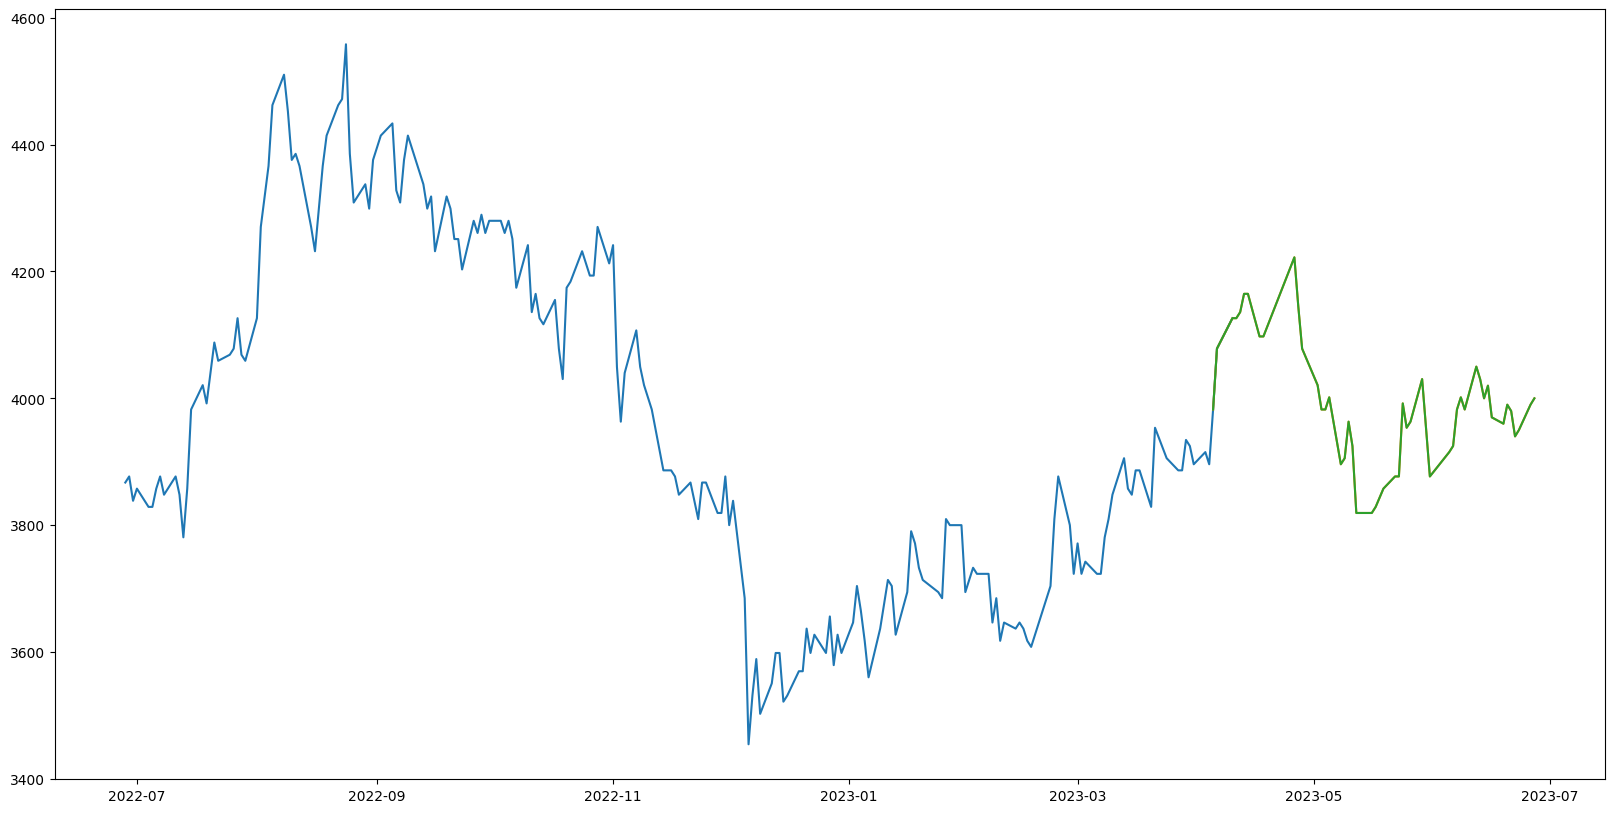

In [13]:
# plot hasil prediksi
valid['Predictions'] = 0
valid['Predictions'] = preds

plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])


In [14]:
# k-NN adalah jenis pembelajaran berbasis instance atau lazy learning, yang tidak membangun model internal tetapi hanya menyimpan contoh pelatihan data.
# yang mana fungsinya hanya didekati secara lokal dan semua perhitungan ditunda hingga evaluasi fungsi.
# Karena algoritma ini bergantung pada jarak untuk klasifikasi, normalisasi data pelatihan dapat meningkatkan akurasinya secara dramatis.

# Baik untuk klasifikasi maupun regresi, teknik yang berguna adalah dengan menetapkan bobot kontribusi tetangga (data terdekat),
# sehingga tetangga yang lebih dekat memberikan kontribusi rata-rata lebih banyak daripada yang lebih jauh.
# Misalnya, skema pembobotan umum terdiri dari pemberian bobot 1/d kepada setiap tetangga, yang mana d adalah jarak ke tetangga.

# k-nearest neighbors (k-NN) adalah algoritma ML yang paling sederhana dan paling populer. di python sklearn sudah menyediakan fungsi untuk k-NN, jadi tinggal import saja.
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scaling data, karena k-NN sangat sensitif terhadap skala data, skala maksudnya adalah rentang nilai dari data tersebut. 0-1 itu jelas berbeda dengan 0-1000
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# pakai GridSearchCV untuk mencari nilai k terbaik (nilai k adalah jumlah tetangga terdekat yang akan digunakan untuk prediksi)
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit model untuk selanjutnya di prediksi
model.fit(x_train, y_train)
preds = model.predict(x_valid)

# hitung lagi rmse nya
rms = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)), 2)))
print(rms)


122.36858129268208


In [15]:
print(valid['Predictions'])

Date
2023-04-05    3982.401123
2023-04-06    4078.362793
2023-04-10    4126.343262
2023-04-11    4126.343262
2023-04-12    4135.939453
2023-04-13    4164.728027
2023-04-14    4164.728027
2023-04-17    4097.555176
2023-04-18    4097.555176
2023-04-26    4222.304688
2023-04-27    4145.535645
2023-04-28    4078.362793
2023-05-02    4020.785889
2023-05-03    3982.401123
2023-05-04    3982.401123
2023-05-05    4001.593506
2023-05-08    3896.035889
2023-05-09    3905.632080
2023-05-10    3963.208984
2023-05-11    3924.824463
2023-05-12    3819.266602
2023-05-15    3819.266602
2023-05-16    3819.266602
2023-05-17    3828.862793
2023-05-19    3857.651367
2023-05-22    3876.843506
2023-05-23    3876.843506
2023-05-24    3991.997314
2023-05-25    3953.612793
2023-05-26    3963.208984
2023-05-29    4030.382080
2023-05-30    3953.612793
2023-05-31    3876.843506
2023-06-05    3915.228271
2023-06-06    3924.824463
2023-06-07    3982.401123
2023-06-08    4001.593506
2023-06-09    3982.401123
2023-06

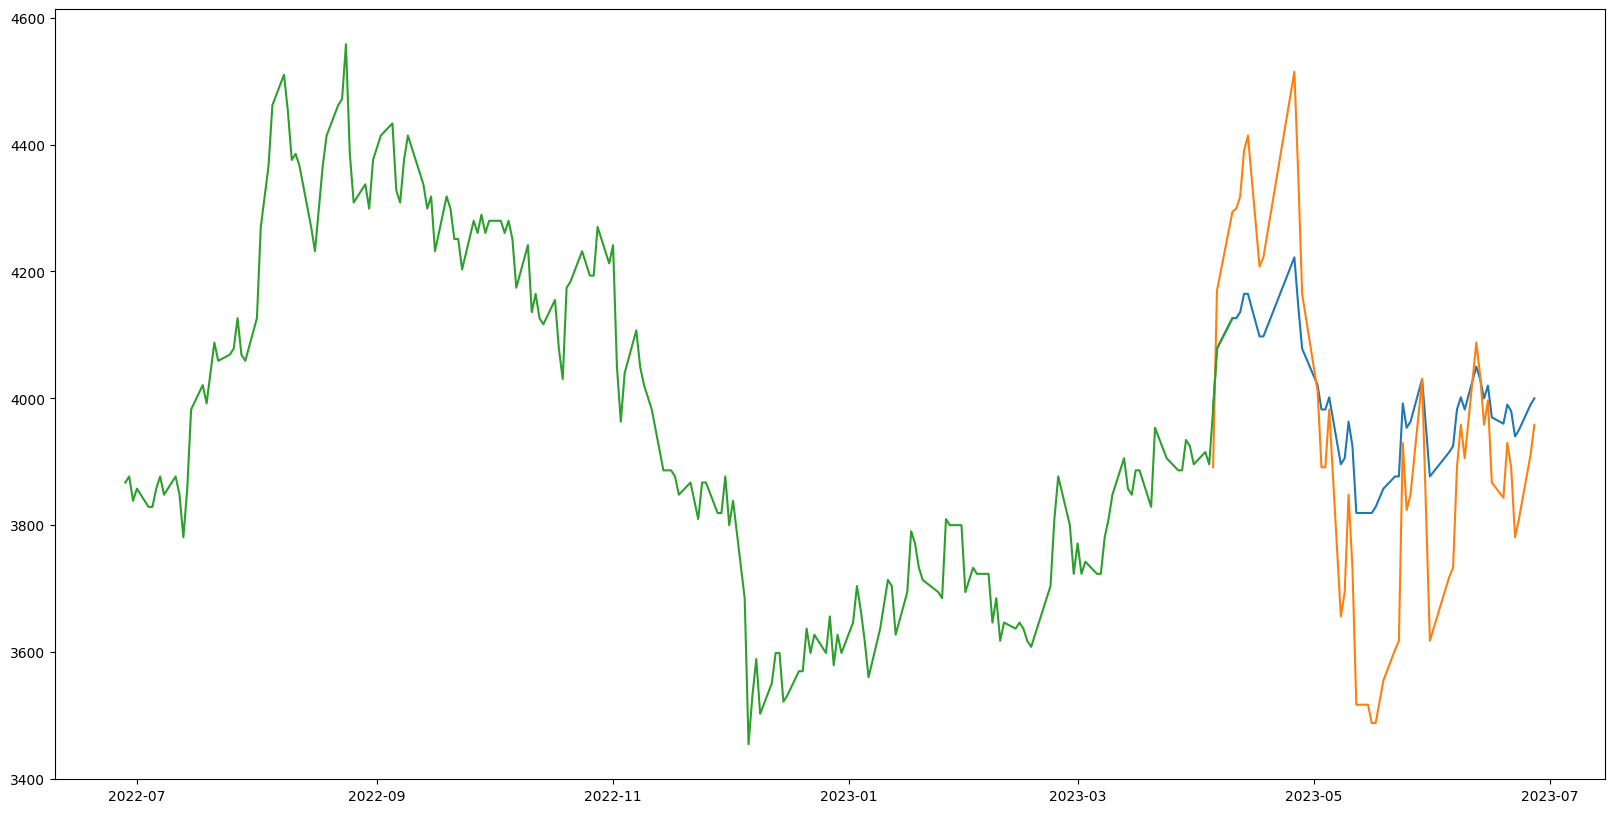

In [16]:
# di plot hasil prediksinya
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Adj Close', 'Predictions']])
plt.plot(train['Adj Close'])


### Data diambil dari Yahoo Finance agar lebih mudah crawlingnya, data valid dan tersinkronasi dengan data dari BEI/IDX